In [1]:
import pandas as pd
import mine_utils as mu
import cluster_utils2 as cu

In [2]:
log_path = "C:/Users/andio/OneDrive/Desktop/University of Ottawa/September_2025_(fall)_Term/Research_DTI6997/Week_10/df_sampled_100_cases.csv"

df = mu.get_log(log_path)

In [3]:
# get trace sequences

filtered = cu.extract_trace_sequences(
    df,
    min_variant_freq=2
)

print("Extracted", len(filtered), "trace sequences.")
filtered.head()

Extracted 100 trace sequences.


trace_str  \
case:concept:name                                                      
37                 Application_Status_-_Prospective Misrepresenta...   
95                 Application_Status_-_Prospective Misrepresenta...   
132                Application_Status_-_Prospective Misrepresenta...   
263                Application_Status_-_Prospective Misrepresenta...   
319                Application_Status_-_Prospective Misrepresenta...   

                     variant  
case:concept:name             
37                 __OTHER__  
95                 __OTHER__  
132                __OTHER__  
263                __OTHER__  
319                __OTHER__

In [4]:
# vectorize

encoding = 'tfidf_svd'
# encoding = 'doc2vec'

encoders, artifacts = cu.vectorize(
    filtered["trace_str"],
    method=encoding
)

for name, X in encoders.items():
    print(name, X.shape)

X = encoders[encoding]
print(f"Using {encoding}:", X.shape)

tfidf_svd (100, 10)
Using tfidf_svd: (100, 10)


In [5]:
# cluster

# input
# cluster_algo = "kmeans"
# cluster_algo = "som"
cluster_algo = "hdbscan"

In [6]:
# find best number of clusters

if cluster_algo in [ 'kmeans', 'som' ]:
    RANGE = range(2, 16)    
    best, results = cu.find_num_clusters(
        X,
        RANGE,
        cluster_algo=cluster_algo
    )
    cu.plot_silhouette_trend(results, f"{cluster_algo.upper()} Silhouette Trend ({encoding.upper()})")
    print("highest score:", best["k"])

In [7]:
# run clustering

# input
chosen_num = 10 # Only used for KMeans & SOM

labels, model = cu.cluster_traces(
    X,
    num_clusters=(chosen_num if cluster_algo != "hdbscan" else None),
    cluster_algo=cluster_algo
)

cluster_stats = cu.mine_from_clusters(
    labels,
    num_clusters=chosen_num,
    sequences_df=filtered.reset_index()
)
cluster_stats

C:\Users\andio\anaconda3\envs\textvec2\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\andio\anaconda3\envs\textvec2\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


cluster  num_traces   pct    avg_len  median_len  unique_variants
0       -1          19  19.0  65.578947        70.0                1
1        0          11  11.0  77.727273        81.0                1
2        1          62  62.0  66.774194        67.0                1
3        2           8   8.0  75.250000        77.0                1

In [10]:
cu.MINER_TYPE = "inductive"     # or "alpha" or "heuristics" applies globally only

In [11]:
metrics_global = cu.evaluate_global_model(df)
metrics_global


Rendering BPMN...


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.566727 to fit


replaying log with TBR, completed traces ::   0%|          | 0/100 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/4373 [00:00<?, ?it/s]

🌐 Global Model (inductive) → Precision: 0.049, Fitness: 0.959, F-score: 0.093, Variability Ratio: 1.000


Method Cluster  NumTraces  Precision  Fitness    FScore  VariabilityRatio
0  Global  Global        100   0.048856  0.95922  0.092976               1.0

In [12]:
''' 
per-cluster process discovery function can only know which cases belong to which cluster if that 
 information is explicitly stored in the filtered dataframe.
'''
filtered["cluster"] = labels


replaying log with TBR, completed traces ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/573 [00:00<?, ?it/s]

🔹 hdbscan_tfidf_svd – Cluster 0: P=0.089, F=0.989, F1=0.163, Var=1.000, Traces=11


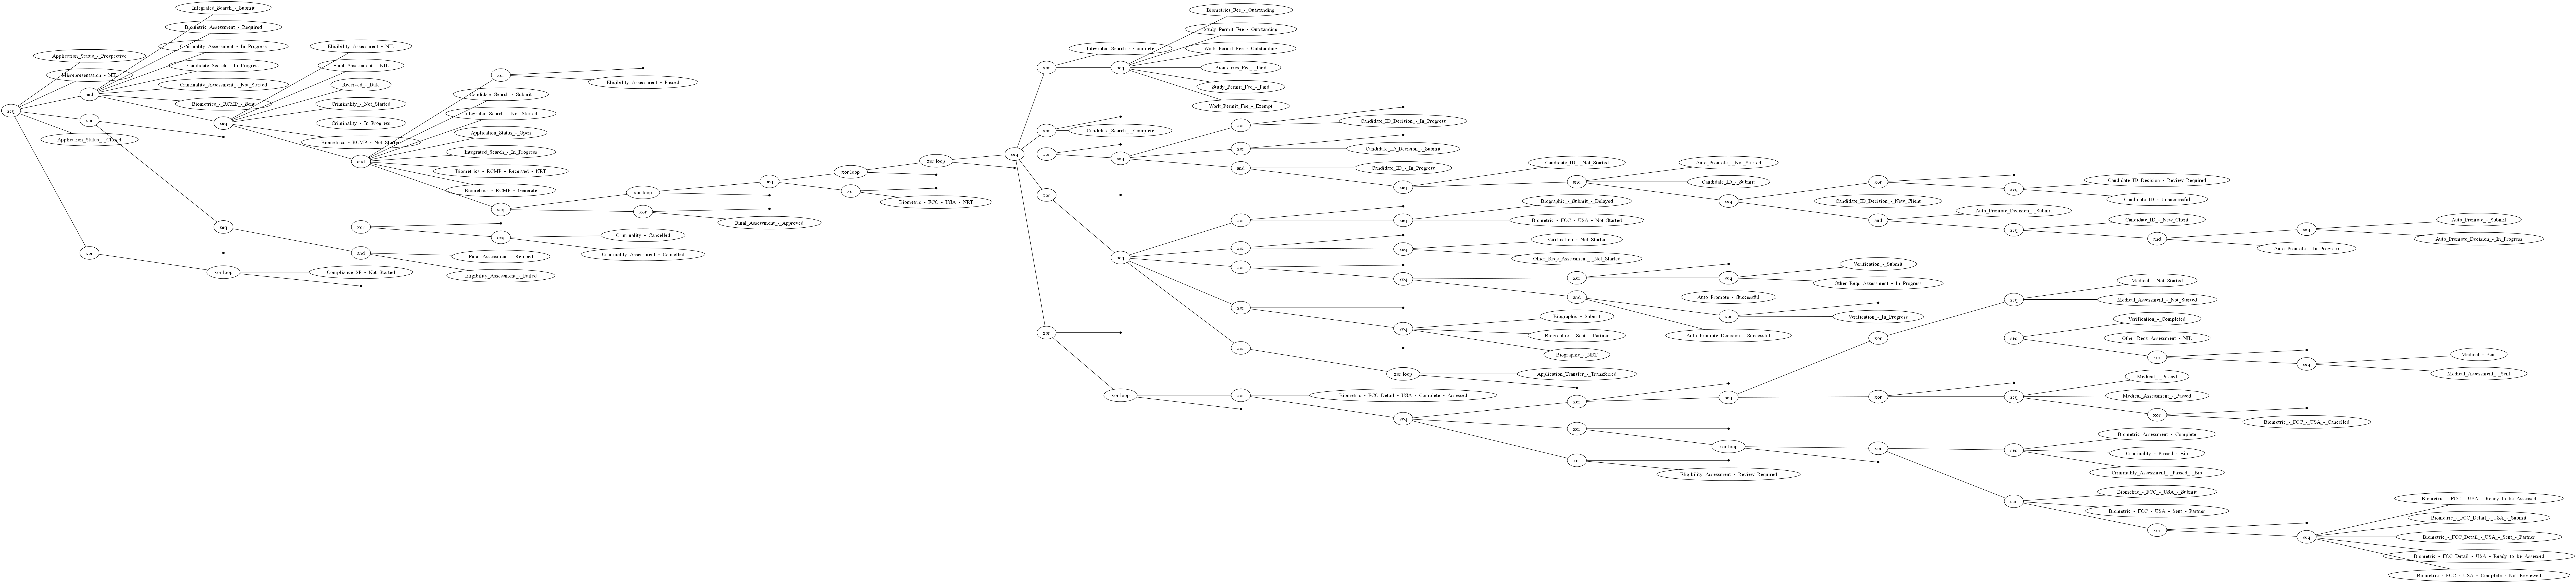

replaying log with TBR, completed traces ::   0%|          | 0/62 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/2619 [00:00<?, ?it/s]

🔹 hdbscan_tfidf_svd – Cluster 1: P=0.055, F=0.950, F1=0.105, Var=1.000, Traces=62


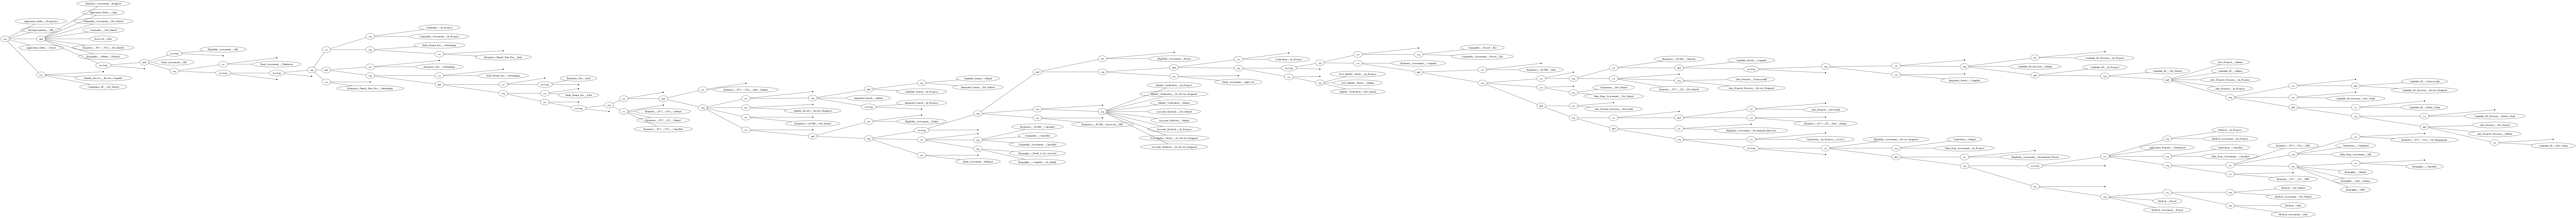

replaying log with TBR, completed traces ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/424 [00:00<?, ?it/s]

🔹 hdbscan_tfidf_svd – Cluster 2: P=0.058, F=0.997, F1=0.109, Var=1.000, Traces=8


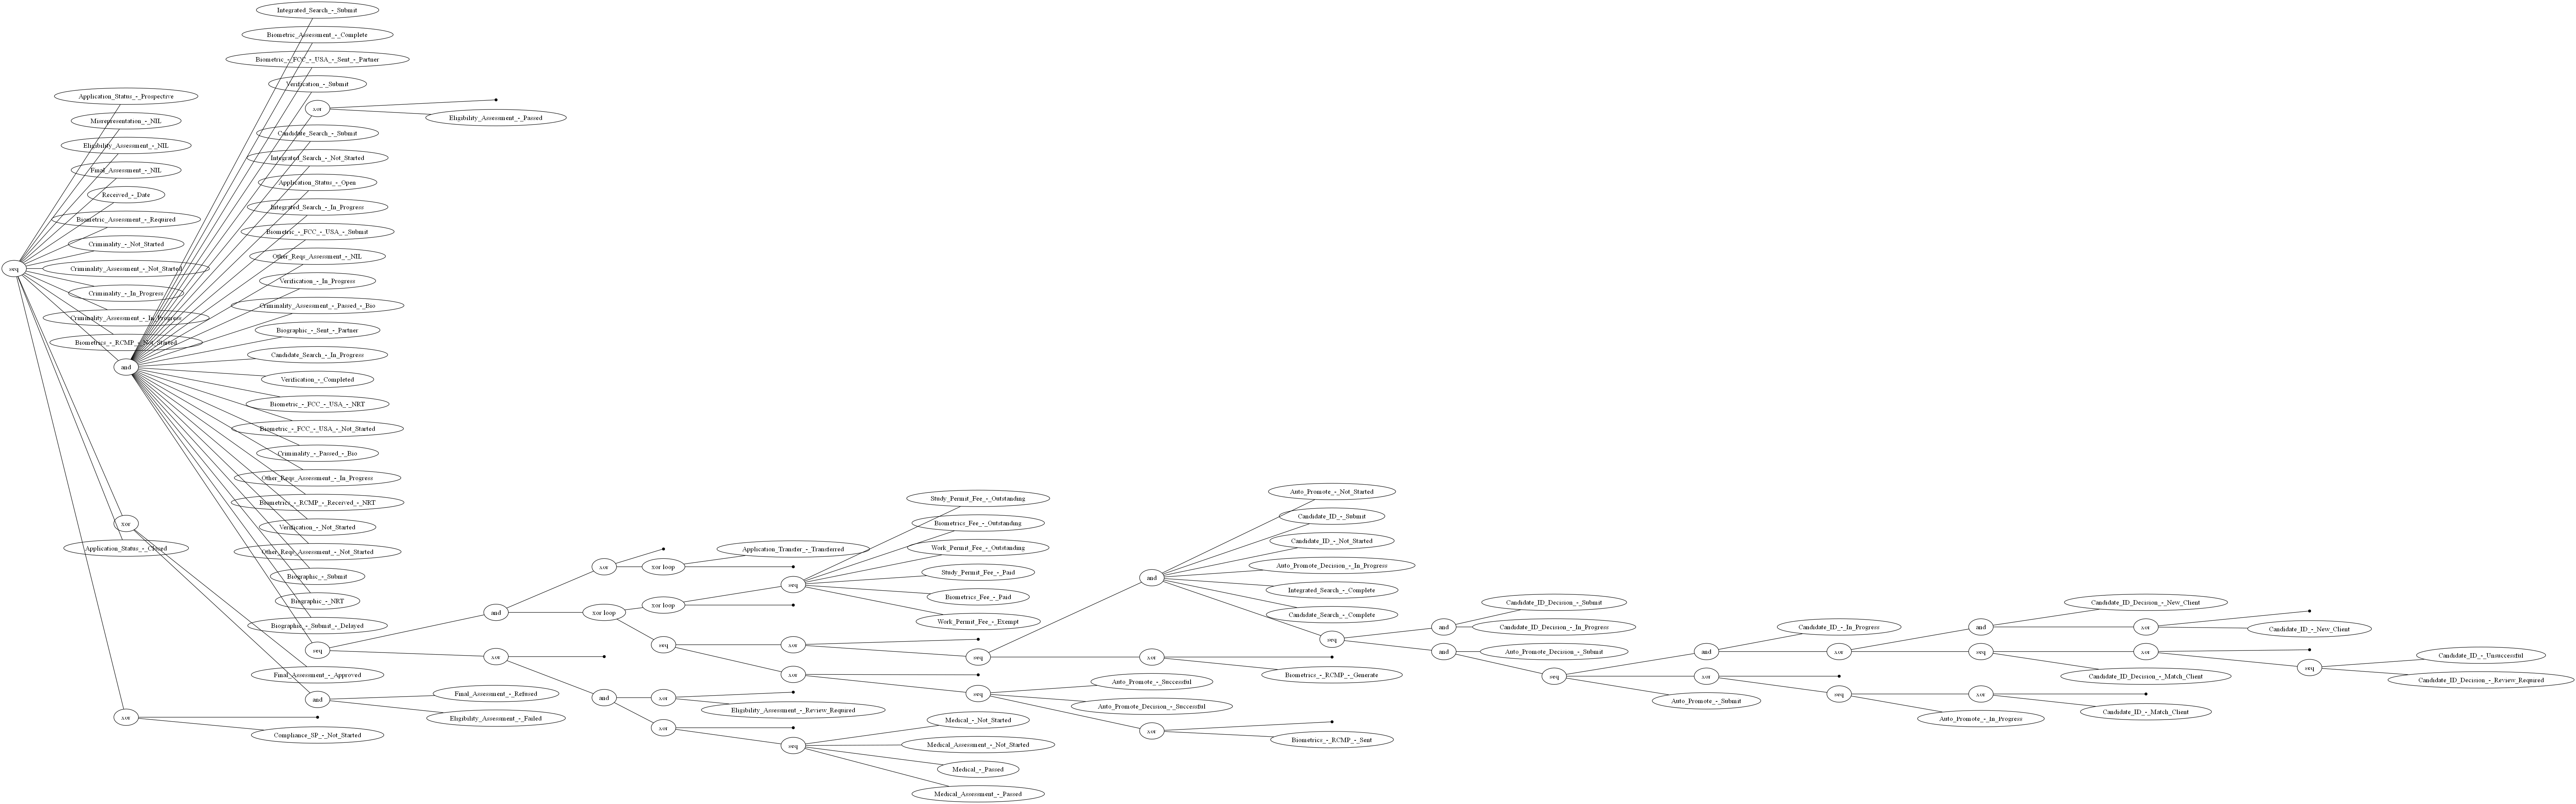

Method    Cluster  NumTraces  Precision   Fitness    FScore  \
0  hdbscan_tfidf_svd  Cluster 0         11   0.088576  0.989076  0.162590   
1  hdbscan_tfidf_svd  Cluster 1         62   0.055466  0.949903  0.104813   
2  hdbscan_tfidf_svd  Cluster 2          8   0.057791  0.997269  0.109251   

   VariabilityRatio         Miner  
0               1.0  IMf-balanced  
1               1.0  IMf-balanced  
2               1.0  IMf-balanced

In [13]:
cluster_metrics = cu.discover_and_evaluate_per_cluster(
    df=df,
    filtered=filtered,     
    cluster_col="cluster",
    method_name=f"{cluster_algo}_{encoding}",
    cluster_metrics_df=None,   
    skip_noise=True,           # True = skip label -1, False = include it (applies to HDBSCAN only)
    miner_variant="balanced",  # or "strict" or "flexible" to choose type of IMF variant
    visualize=True,
    model_type="tree"   # or bpmn or pn or dfg to choose type of visual generated
)

display(cluster_metrics)